In [1]:
import sys
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal
import random
import copy

In [2]:
class Particle:
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight                                                                      # パーティクルの重み（初期値）
        
    def motion_update(self, nu, omega, time, noise_rate_pdf):
        ns = noise_rate_pdf.rvs()                                                                 # 式(5.9)
        noised_nu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)         # 式(5.12)
        noised_omega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)   # 式(5.12)
        self.pose = IdealRobot.state_transition(noised_nu, noised_omega, time, self.pose)         # パーティクルの姿勢を更新
        
    def observation_update(self, observation, envmap, distance_dev_rate, direction_dev):
        for d in observation:
            obs_pos = d[0]
            obs_id = d[1]
            
            # パーティクルの位置と地図からランドマークの距離と方角を算出(距離は標準偏差にかける)
            pos_on_map = envmap.landmarks[obs_id].pos
            particle_suggest_pos = IdealCamera.observation_function(self.pose, pos_on_map)
            
            # 尤度の計算
            distance_dev = distance_dev_rate*particle_suggest_pos[0]                              # 距離のセンサ値の標準偏差
            cov = np.diag(np.array([distance_dev**2, direction_dev**2]))                          # 共分散行列
            self.weight *= multivariate_normal(mean=particle_suggest_pos, cov=cov).pdf(obs_pos)   # 重みに尤度を反映 右辺は(5.24)

In [3]:
class Mcl:
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.11, "oo":0.2},
                 distance_dev_rate=0.14, direction_dev=0.05):
        self.particles = [Particle(init_pose, 1.0/num) for i in range(num)]
        self.map = envmap
        self.distance_dev_rate=0.14                                       # 距離のセンサ値の標準偏差（尤度関数に使用）
        self.direction_dev=0.05                                           # 角度のセンサ値の標準偏差（尤度関数に使用）
        
        v = motion_noise_stds                                             # パーティクルの動きの雑音の標準偏差
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])     # 与えられた標準偏差を要素に持つ対角行列を作る
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)           # 与えられた標準偏差をもつ四次元のガウス分布を作る
        
        self.ml = self.particles[0]                                       # 代表パーティクル(maximum likehood,重みが最大)
        self.pose = self.ml.pose                                          # 代表パーティクルの姿勢
        
    def set_ml(self):
        i = np.argmax([p.weight for p in self.particles])                 # 重みが最大のパーティクルの参照を選ぶ
        self.ml = self.particles[i]
        self.pose = self.ml.pose                                          # 代表パーティクルの姿勢
        
    def motion_update(self, nu, omega, time):
        for p in self.particles:
            p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)         # particlesに対してParticleのmotion_updateを呼び出す
        
    def observation_update(self, observation):
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev)
        self.set_ml()                                                     # 代表パーティクルを選ぶ（リサンプリング前に実行）
        self.resampling()                                                 # リサンプリング
        
    def resampling(self):                                                 # 系統サンプリング
        ws = np.cumsum([e.weight for e in self.particles])                # 重みを累積して足していく（最後の要素が重みの合計になる）
        if ws[-1] < 1e-100:
            ws = [e + 1e-100 for e in ws]                                 # 重みの合計が0のときの処理
        
        step = ws[-1] / len(self.particles)                               # 正規化されていない場合はステップが重みの合計値/Nになる
        r = random.uniform(0.0, step)                                     # 0.0～stepの中からランダムにrを選ぶ
        cur_pos = 0
        ps = []                                                           # 抽出するパーティクルのリスト
        
        while(len(ps) < len(self.particles)):
            if r < ws[cur_pos]:
                ps.append(self.particles[cur_pos])
                r += step
            else:
                cur_pos += 1
        
        self.particles = [copy.deepcopy(e) for e in ps]                   # パーティクルを重みを均一にして更新
        for p in self.particles:
            p.weight = 1.0 / len(self.particles)                          # 重みの正規化
        
    def draw(self, ax, elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2])*p.weight*len(self.particles) for p in self.particles]    # 重みの大きさを矢印の長さにする
        vys = [math.sin(p.pose[2])*p.weight*len(self.particles) for p in self.particles]    # 重みの大きさを矢印の長さにする
        elems.append(ax.quiver(xs, ys, vxs, vys, angles='xy', scale_units='xy', scale=1.5, color="blue", alpha=0.5))

In [4]:
class EstimationAgent(Agent):
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self, observation=None):
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)    # 前回の姿勢からエージェントが姿勢推定
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.estimator.observation_update(observation)
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.estimator.draw(ax, elems)                                                     # パーティクルを描画
        
        x, y, t = self.estimator.pose                                                      # 代表パーティクルの姿勢を表示
        s = "({:.2f}, {:.2f}, {})".format(x, y, int(t*180/math.pi)%360)
        elems.append(ax.text(x, y+0.1, s, fontsize=8))

<IPython.core.display.Javascript object>


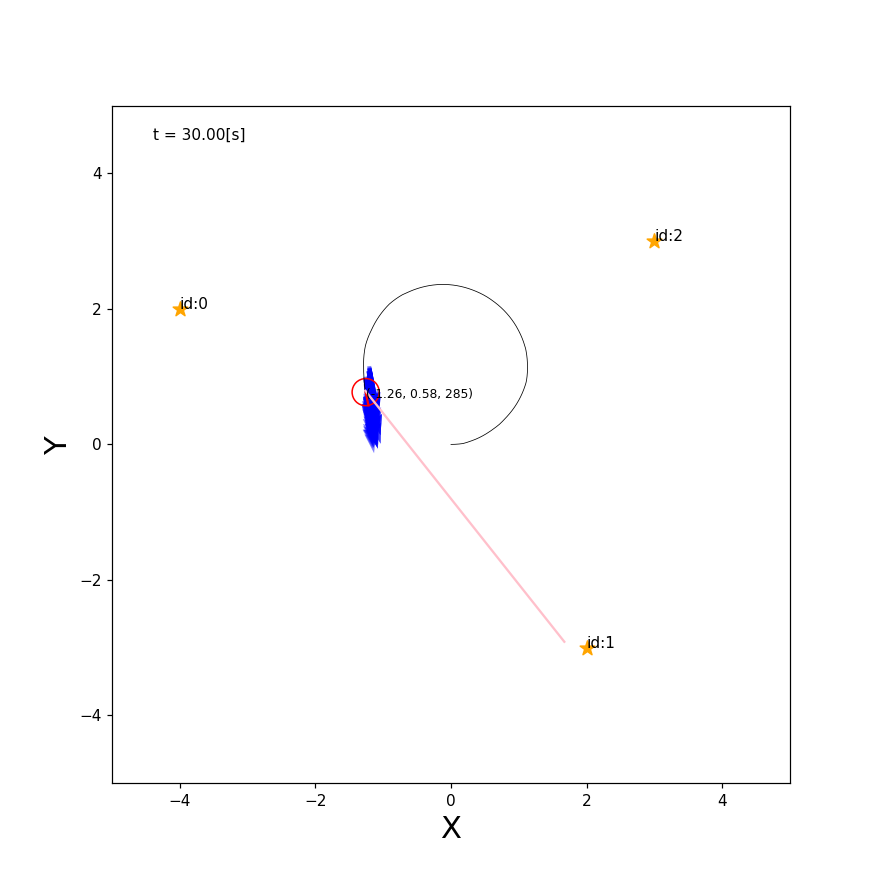

In [5]:
def trial():
    time_interval = 0.1
    world = World(30, time_interval, debug=False)
    
    # 地図を作成してランドマークを追加
    m = Map()
    for ln in [(-4, 2), (2, -3), (3, 3)]:
        m.append_landmark(LandMark(*ln))
    world.append(m)
    
    # ロボットを作る
    initial_pose = np.array([0, 0, 0]).T
    estimator = Mcl(m, initial_pose, 100)                                        # パーティクルフィルタを作る 地図を持たせる
    circling = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, estimator)     # estimatorを渡す
    r = Robot(initial_pose, sensor=Camera(m), agent=circling, color="red")
    world.append(r)

    # アニメーション実行
    world.draw()
    
trial()